# Corporate quaterly earning call analysis

# Data Scrapping for NLP
- Below code is to scrap the data from SkingAlpha website where publicly listed companies data is available.
- selenium webdriver and BeautifulSoup libraries are used to scrap the data from website

## Libraries

In [38]:
# Standard Libraries
import pandas as pd
from datetime import datetime,time
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Scraping Libraries
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
import re

# NLP Libraries
from textblob import TextBlob
import textstat

## Functions

In [40]:
def getSentimentScore(text):
    return TextBlob(str(text)).sentiment.polarity
    
def getSubjectivity(text):
    return TextBlob(str(text)).sentiment.subjectivity

def getSentiments(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

def open_browser(alt_user_name = 'Thank you for your website'):
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('window-size=1920x1080')
    chrome_options.add_argument(f'user-agent={alt_user_name}')
    driver = webdriver.Chrome(ChromeDriverManager().install())
    return driver

### As a part of our project, we are targeting top 50 companies of S&P 500 index
### Top 50 companies of S&P500 index is taken from source: https://dailypik.com/top-50-companies-sp-500/

## CompanyName : Symbol

Apple Inc.:AAPL | Microsoft Corp.:MSFT | Amazon.com Inc.:AMZN | Facebook Inc. Class A:FB | Alphabet Inc. Class A:GOOGL | Alphabet Inc. Class C:GOOG | Tesla:TSLA | Berkshire Hathaway Inc. Class B:BRK.B | JPMorgan Chase & Co.:JPM | Johnson & Johnson:JNJ | NVIDIA Corp.:NVDA | Visa Inc. Class A:V | PayPal Holdings Inc.:PYPL | Walt Disney Company:DIS | Procter & Gamble Co.:PG | UnitedHealth Group Inc.:UNH | Home Depot Inc.:HD | MasterCard Inc. Class A:MA | Bank of America Corp.:BAC | Intel Corp.:INTC | Netflix Inc.:NFLX | Comcast Corp. Class A:CMCSA | Verizon Communications Inc.:VZ | Adobe Inc.:ADBE | salesforce.com Inc.:CRM | Abbott Laboratories:ABT | Exxon Mobil Corp.:XOM | AT&T Inc.:T | Walmart Inc.:WMT | Thermo Fisher Scientific Inc.:TMO | Cisco Systems Inc.:CSCO | Broadcom Inc.:AVGO | Pfizer Inc.:PFE | Coca-Cola Company:KO | Merck & Co. Inc.:MRK | AbbVie Inc.:ABBV | PepsiCo Inc.:PEP | Chevron Corp.:CVX | NIKE Inc. Class B:NKE | Accenture Plc Class A:ACN | Eli Lilly and Company:LLY | Texas Instruments Inc.:TXN | QUALCOMM Inc.:QCOM | Medtronic Plc:MDT | McDonald's Corp.:MCD | NextEra Energy Inc.:NEE | Costco Wholesale Corp.:COST | Danaher Corp.:DHR | Wells Fargo & Company:WFC | Union Pacific Corp.:UNP
### This companies are sorted based on Market Capitalization

In [41]:
def scrap_transcripts(urls,browser):
    print('scraping transcripts')
    list_of_dicts   = []
    for url in urls:
        print('Opening url:',url)
        browser.get(url)
        soup                    = BeautifulSoup(browser.page_source)
        p_elements              = [item.text for item in soup.find_all('p')]
        title                   = p_elements[0]
        print('scraping - ',title)
        sleep(15)

        # Finding the seperation between main speech(es) and QA section
        done = False
        for item_num in range(len(p_elements)):
            if done == True:
                break
            elif p_elements[item_num] == 'Question-and-Answer Session':
                pre_QA_title         = p_elements[:item_num - 1]
                post_QA_title         = p_elements[item_num:]
                done                  = True
            else:
                pass

        #speech = ' '.join([i for i in pre_QA_title if len(i) >= 35][1:])
        speech = ' '.join([i for i in pre_QA_title])
        #QA     = ' '.join([i for i in post_QA_title if len(i) >= 25])
        QA     = ' '.join([i for i in post_QA_title])
        speech_score = getSentimentScore(speech)
        QA_score = getSentimentScore(QA)
        current_dict = {
            'qtr_year'                  : re.findall("Q\d{1,5}\s\d{4}",title),
            'title'                     : title,
            'ticker'                    : title[title.find(":")+len(":"):title.rfind(")")],
            'speech'                    : speech,
            'speech_sentiment_score'    : speech_score,
            'speech_subjectivity'       : getSubjectivity(speech),
            'speech_complexity'         : textstat.gunning_fog(speech),
            'speech_overall_sentiments' : getSentiments(speech_score), 
            'Q_and_A'                   : QA,
            'QA_sentiment_score'        : QA_score,
            'QA_subjectivity'           : getSubjectivity(QA),
            'QA_complexity'             : textstat.gunning_fog(QA),
            'QA_overall_sentiments'     : getSentiments(QA_score),
            'URL'                       : url
        }
        list_of_dicts.append(current_dict)
    return list_of_dicts

In [ ]:
# Scraping urls of each transcript before the next step.
browser         = open_browser()
main_df = pd.DataFrame()
#comp_list = ['AAPL','MSFT','AMZN','FB','GOOGL','GOOG','TSLA','BRK.B','JPM','JNJ','NVDA','PYPL','DIS','PG','UNH','HD','MA','BAC','INTC','NFLX','CMCSA','VZ','ADBE','CRM','ABT','XOM','T','WMT','TMO','CSCO','AVGO','PFE','KO','MRK','ABBV','PEP','CVX','NKE','ACN','LLY','TXN','QCOM','MDT','MCD','NEE','COST','DHR','WFC','UNP']
#done: 'AAPL','MSFT','AMZN','FB','GOOGL','GOOG','TSLA','BRK.B','JPM','JNJ','NVDA','PYPL','DIS','PG','HD','MA','BAC','INTC','NFLX','CMCSA','VZ','ADBE','CRM','UNH',
comp_list = ['ABT','XOM','T','WMT','TMO','CSCO','AVGO','PFE','KO','MRK','ABBV','PEP','CVX','NKE','ACN','LLY','TXN','QCOM','MDT','MCD','NEE','COST','DHR','WFC','UNP']
#b_url='https://seekingalpha.com/earnings/earnings-call-transcripts/'
base_url1 = 'https://seekingalpha.com/search?q='
base_url2 = '&type=keyword&tab=transcripts'
#get URLs to be scrapped - Approx 10 URLs/page
for sym in comp_list:
    df = pd.DataFrame(columns = ['qtr_year','title','ticker', 'speech', 
                            'speech_sentiment_score','speech_subjectivity', 'speech_complexity', 'speech_overall_sentiments',
                            'Q_and_A','QA_sentiment_score','QA_subjectivity','QA_complexity','QA_overall_sentiments','url_source'])
    data = []
    urls = []
    current_ts_list = base_url1+sym+base_url2
    print('URL to get latest 10 transcripts of ',sym, ' : ' ,current_ts_list)
    browser.get(current_ts_list)
    sleep(15)
    par_elements = browser.find_elements_by_class_name('item-link')
    for el in par_elements:
        chld_element = el.find_elements_by_tag_name('a')
        urls.append(chld_element[0].get_attribute('href'))
    print('no of urls:', len(urls),' for :',sym)
    data = scrap_transcripts(urls,browser)

    #convert data to dataframe
    df = df.append(data)
    file = 'G:\\Project\\Git_Repos\\NLP-Earning-call-analysis\\Data\\NLP_conf_call_data_'+sym+'.xlsx'
    df.to_excel(file)
    main_df = df
browser.close()

#write to excel - export data
#path = f_n = 'G:\\Project\\Git_Repos\\NLP-Earning-call-analysis\\Data\\NLP_conf_call_data.xlsx'
#main_df.to_excel("../Data/NLP_conf_call_data.xlsx")

In [1]:
import re,os
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime,date,timedelta

#wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.draw.dispersion import dispersion_plot

In [2]:
#read file
df = pd.read_excel("G:\\Project\\Git_Repos\\NLP-Earning-call-analysis\\Data\\NLP_conf_call_data.xlsx")
df1 = df

In [34]:
'''#Extract date from title
pattern = '(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|June?|July?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\s+\d{1,2},\s+\d{4}'
df1 = df
release_dt = []
for i in range(len(df1)):
    str_dt = re.findall(pattern,df['title'][i])
    #print(df['title'][i])
    #print(str_dt[0])
    release_dt.append(datetime.strptime(str_dt[0],"%B %d, %Y").strftime('%Y-%m-%d'))
df1.insert(2,'release_dt',release_dt)'''

'#Extract date from title\npattern = \'(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|June?|July?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)\\s+\\d{1,2},\\s+\\d{4}\'\ndf1 = df\nrelease_dt = []\nfor i in range(len(df1)):\n    str_dt = re.findall(pattern,df[\'title\'][i])\n    #print(df[\'title\'][i])\n    #print(str_dt[0])\n    release_dt.append(datetime.strptime(str_dt[0],"%B %d, %Y").strftime(\'%Y-%m-%d\'))\ndf1.insert(2,\'release_dt\',release_dt)'

In [61]:
#df1.insert('prev_day_ret%','')
#df1.insert('release_day_ret%','')
#df1.insert('next_day_ret%','')
prev_day_ret=[]
release_day_ret=[]
next_day_ret = []
for i in range(len(df1)):
    #print(i,df1['ticker'][i],df1['release_dt'][i])
    stock_data = yf.Ticker(df1['ticker'][i])
    start_dt = (datetime.strptime(df1['release_dt'][i],'%Y-%m-%d')-timedelta(4)).strftime('%Y-%m-%d')
    end_dt = (datetime.strptime(df1['release_dt'][i],'%Y-%m-%d')+timedelta(5)).strftime('%Y-%m-%d')
    stock_data_yf = stock_data.history(start = start_dt,end = end_dt)
    #print(df1['ticker'][i],'--',start_dt,'--',end_dt)
    if stock_data_yf.empty:
        print(df1['ticker'][i],'--',start_dt,'--',end_dt)
    for j in range(len(stock_data_yf)):
        #print(stock_data_yf)
        #converting index to datetime string object to compare with release_dt from main dataframe
        # this way we can compare returns and validate if there were any big movement before release of earning call?
        dt = datetime.strptime(str(stock_data_yf.index[j]), '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d')
        if dt == df1['release_dt'][i]:
            ret1 = round(100*((stock_data_yf['Close'][j-1]-stock_data_yf['Close'][j-2])/stock_data_yf['Close'][j-2]),2) #df1['prev_day_ret%'][i] = 
            ret2 = round(100*((stock_data_yf['Close'][j]-stock_data_yf['Close'][j-1])/stock_data_yf['Close'][j-1]),2) #df1['release_day_ret%'][i] = 
            ret3 = round(100*((stock_data_yf['Close'][j+1]-stock_data_yf['Close'][j])/stock_data_yf['Close'][j]),2) #df1['next_day_ret%'][i] = 
    prev_day_ret.append(ret1)
    release_day_ret.append(ret2)
    next_day_ret.append(ret3)
df1.insert(5,'prev_day_ret%',prev_day_ret)
df1.insert(6,'release_day_ret%',release_day_ret)
df1.insert(7,'next_day_ret%',next_day_ret)
#df1.to_excel("G:\\Project\\Git_Repos\\NLP-Earning-call-analysis\\Data\\updated.xlsx")

In [ ]:
speech = ''
q_and_a = ''
for i in range(len(df1)):
    speech += df["speech"][i]
    q_and_a += df["Q_and_A"][i]

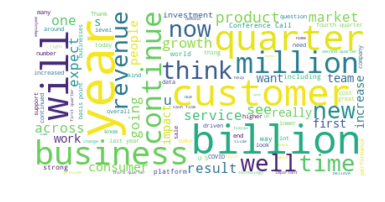

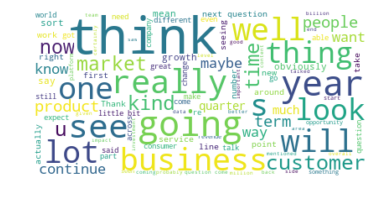

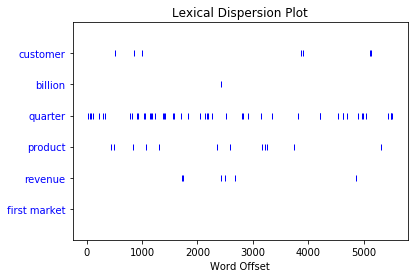

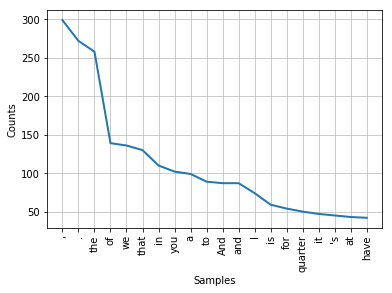

In [39]:
#Visualization
wc_speech = WordCloud(max_words=100,max_font_size=60,background_color="white").generate(speech)
plt.imshow(wc_speech,interpolation="bilinear")
plt.axis("off")
plt.show()

wc_qa = WordCloud(max_words=100,max_font_size=60,background_color="white").generate(q_and_a)
plt.imshow(wc_qa,interpolation="bilinear")
plt.axis("off")
plt.show()


#dispersionp plot
#show distribution 
wl = nltk.word_tokenize(df["Q_and_A"][0])
keywords = ["customer","billion","quarter","product","revenue","first market"]
dispersion_plot(wl,keywords)

#frequency plot
freqdist = nltk.FreqDist(wl)
freqdist.plot(20)

In [59]:
#Find whether the returns are driven by speech sentiment or QA sentiment
driving_sentiment_max = df1[['speech_sentiment_score','QA_sentiment_score']].idxmax(axis=1)
driving_sentiment_min = df1[['speech_sentiment_score','QA_sentiment_score']].idxmin(axis=1)
driving_sentiment = []
for i in range(len(df1)):
    if df1['next_day_ret%'][i] > df1['release_day_ret%'][i]:
        driving_sentiment.append(re.findall('^[^_]+(?=_)',driving_sentiment_max[i])[0])
    elif df1['next_day_ret%'][i] < df1['release_day_ret%'][i]:
        driving_sentiment.append(re.findall('^[^_]+(?=_)',driving_sentiment_min[i])[0])
    else:
        driving_sentiment.append('NA')
if 'Driving_Sentiment' in df1.keys():
    df1['Driving_Sentiment'] = driving_sentiment
else:
    df1.insert(18,'Driving_Sentiment',driving_sentiment)

In [33]:
df1.groupby('Driving_Sentiment').count()

,sq_no,qtr_year,release_dt,title,ticker,prev_day_ret%,release_day_ret%,next_day_ret%,speech,speech_sentiment_score,speech_subjectivity,speech_complexity,speech_overall_sentiments,Q_and_A,QA_sentiment_score,QA_subjectivity,QA_complexity,QA_overall_sentiments,url_source,URL_SOURCE
Driving_Sentiment,,,,,,,,,,,,,,,,,,,,
QA,114,81,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,0,114
speech,106,64,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,106,0,106


In [3]:
df1.head()

,sq_no,qtr_year,release_dt,title,ticker,prev_day_ret%,release_day_ret%,next_day_ret%,speech,speech_sentiment_score,speech_subjectivity,speech_complexity,speech_overall_sentiments,Q_and_A,QA_sentiment_score,QA_subjectivity,QA_complexity,QA_overall_sentiments,url_source,URL_SOURCE
0,1,Q1 2021,2021-01-27,Apple Inc. (NASDAQ:AAPL) Q1 2021 Results Confe...,AAPL,0.17,-0.77,-3.50,Apple Inc. (NASDAQ:AAPL) Q1 2021 Results Confe...,0.180685,0.496912,12.63,Positive,Question-and-Answer Session Operator We'll go ...,0.164414,0.461982,8.18,Positive,NaN,https://seekingalpha.com/article/4401478-apple...
1,2,Q4 2020,2020-10-29,Apple Inc. (NASDAQ:AAPL) Q4 2020 Earnings Conf...,AAPL,-4.64,3.71,-5.60,Apple Inc. (NASDAQ:AAPL) Q4 2020 Earnings Conf...,0.166081,0.487233,11.61,Positive,Question-and-Answer Session Operator Certainly...,0.168146,0.466873,8.82,Positive,NaN,https://seekingalpha.com/article/4382943-apple...
2,3,Q3 2020,2020-07-30,Apple Inc. (NASDAQ:AAPL) Q3 2020 Results Confe...,AAPL,1.91,1.22,10.47,Apple Inc. (NASDAQ:AAPL) Q3 2020 Results Confe...,0.161981,0.477323,12.15,Positive,"Question-and-Answer Session Operator Yes, that...",0.169234,0.444186,8.53,Positive,NaN,https://seekingalpha.com/article/4362707-apple...
3,4,Q2 2020,2020-04-30,Apple Inc. (NASDAQ:AAPL) Q2 2020 Results Confe...,AAPL,3.28,2.12,-1.62,Apple Inc. (NASDAQ:AAPL) Q2 2020 Results Confe...,0.191465,0.444778,12.16,Positive,Question-and-Answer Session Operator Yes. That...,0.148605,0.419132,7.67,Positive,NaN,https://seekingalpha.com/article/4341792-apple...
4,5,Q1 2020,2020-01-28,Apple Inc. (NASDAQ:AAPL) Q1 2020 Results Confe...,AAPL,-2.94,2.83,2.10,Apple Inc. (NASDAQ:AAPL) Q1 2020 Results Confe...,0.190458,0.460144,11.71,Positive,Question-and-Answer Session Operator Yes. That...,0.168459,0.439424,8.48,Positive,NaN,https://seekingalpha.com/article/4319666-apple...


In [23]:
#Find possible early release
diff_prev = (df1['prev_day_ret%'].abs()-df1['release_day_ret%'].abs()).abs()
diff_next = (df1['next_day_ret%'].abs()-df1['release_day_ret%'].abs()).abs()
result = []
for i in range(len(diff_prev)):
    if diff_prev[i]>diff_next[i]:
        result.append(1)
    else:
        result.append(0)
if 'poss_early_release' in df1.keys():
    df1['poss_early_release'] = result
else:
    df1.insert(8,'poss_early_release',result)

In [60]:
df1.head(5)

,sq_no,qtr_year,release_dt,title,ticker,prev_day_ret%,release_day_ret%,next_day_ret%,poss_early_release,speech,...,speech_complexity,speech_overall_sentiments,Q_and_A,QA_sentiment_score,QA_subjectivity,QA_complexity,Driving_Sentiment,QA_overall_sentiments,url_source,URL_SOURCE
0,1,Q1 2021,2021-01-27,Apple Inc. (NASDAQ:AAPL) Q1 2021 Results Confe...,AAPL,0.17,-0.77,-3.50,0,Apple Inc. (NASDAQ:AAPL) Q1 2021 Results Confe...,...,12.63,Positive,Question-and-Answer Session Operator We'll go ...,0.164414,0.461982,8.18,QA,Positive,NaN,https://seekingalpha.com/article/4401478-apple...
1,2,Q4 2020,2020-10-29,Apple Inc. (NASDAQ:AAPL) Q4 2020 Earnings Conf...,AAPL,-4.64,3.71,-5.60,0,Apple Inc. (NASDAQ:AAPL) Q4 2020 Earnings Conf...,...,11.61,Positive,Question-and-Answer Session Operator Certainly...,0.168146,0.466873,8.82,speech,Positive,NaN,https://seekingalpha.com/article/4382943-apple...
2,3,Q3 2020,2020-07-30,Apple Inc. (NASDAQ:AAPL) Q3 2020 Results Confe...,AAPL,1.91,1.22,10.47,0,Apple Inc. (NASDAQ:AAPL) Q3 2020 Results Confe...,...,12.15,Positive,"Question-and-Answer Session Operator Yes, that...",0.169234,0.444186,8.53,QA,Positive,NaN,https://seekingalpha.com/article/4362707-apple...
3,4,Q2 2020,2020-04-30,Apple Inc. (NASDAQ:AAPL) Q2 2020 Results Confe...,AAPL,3.28,2.12,-1.62,1,Apple Inc. (NASDAQ:AAPL) Q2 2020 Results Confe...,...,12.16,Positive,Question-and-Answer Session Operator Yes. That...,0.148605,0.419132,7.67,QA,Positive,NaN,https://seekingalpha.com/article/4341792-apple...
4,5,Q1 2020,2020-01-28,Apple Inc. (NASDAQ:AAPL) Q1 2020 Results Confe...,AAPL,-2.94,2.83,2.10,0,Apple Inc. (NASDAQ:AAPL) Q1 2020 Results Confe...,...,11.71,Positive,Question-and-Answer Session Operator Yes. That...,0.168459,0.439424,8.48,QA,Positive,NaN,https://seekingalpha.com/article/4319666-apple...


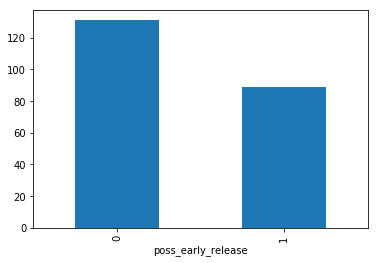

In [36]:
df1.groupby('poss_early_release').size().plot.bar()
#df1['poss_early_release'].value_counts().plot.bar()

### IGNORE BELOW CODE

In [53]:
a = widgets.Dropdown(
    options=df1.ticker.unique(),
    #value='2',
    description='Symbols:',
    disabled=False,
)

In [ ]:
a.on_trait_change(handle_change, name="value")

In [51]:
def dropdown_eventhandler(change):
    print(change.new)
a.observe(dropdown_eventhandler, names='value')
display(a)

Dropdown(description='Symbols:', options=('AAPL', 'MSFT', 'AMT', 'EMHTF', 'AMZN', 'FB', 'FBK', 'EIHDF', 'GOOG'…

In [55]:
def on_dropdown_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        print('do something with the change')
dropdown =  ipywidgets.Dropdown({options=['one','two','three'],
                                 value='one'})
dropdown.observe(on_dropdown_change)

SyntaxError: invalid syntax (<ipython-input-55-0dfe029db2b4>, line 4)

In [58]:
from ipywidgets import Dropdown

def handle_change():
    print(type_sel.value)

type_sel = Dropdown(description="Keypoint type", options=df1.ticker.unique())
type_sel.on_trait_change(handle_change, name="value")
display(type_sel)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  import sys


Dropdown(description='Keypoint type', options=('AAPL', 'MSFT', 'AMT', 'EMHTF', 'AMZN', 'FB', 'FBK', 'EIHDF', '…

PCG


In [62]:
df1.to_excel("G:\\Project\\Git_Repos\\NLP-Earning-call-analysis\\Data\\updated.xlsx")